## 五十嵐さんのコードを追加データで検証する
  
#### 使用データ
- 病院で取得した動画
    - 2症例6データ
    - z01
        - movie1~4
        - day1, 14, 28
    - z02
        - movie1~4
        - day1, 14, 28
          
#### 解析項目
- 各動画データごとに以下の項目を出力する。
    - X座標の変化
    - X座標の階差
    - 抽出区間での親指先端のX座標の変化
- 標準偏差を重症度ごとにプロット
- Additional
    - 同じ患者さんの経時(取得回数による)変化

---

In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
#%matplotlib nbagg
from collections import defaultdict

import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# set function
def makedir_if_notexists(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
    elif not os.path.isdir(dirpath):
        sys.stderr.write('The filepath has already existed.')
        exit(1) # exit(1)は異常終了

---

## 1. データの確認

In [3]:
file_path = "data/Clinical Research_Day1,Day28(hospital, patient) - Clinical Research_Day1,Day28(hospital, patient).csv"
df = pd.read_csv(file_path)
df[:2]

,タイムスタンプ,現在こちらに回答している患者様のお名前をフルネームで入力して下さい。,Day,1. この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [ボタン掛けや靴ひも結びを含め、自分で身支度ができますか？],1. この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [就寝、起床の動作ができますか？],1. この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [いっぱい水の入ったコップを口元まで運べますか？],1. この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [戸外の平坦な道を歩けますか？],1. この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [体を洗いタオルで拭くことができますか？],1. この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [腰を曲げて床にある衣服を拾い上げられますか？],1. この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [（回転式の）蛇口の開閉ができますか？],...,11. この半年をふりかえり、以下にあてはまることはありましたか？チェック をしてください。 [住所の変更],11. この半年をふりかえり、以下にあてはまることはありましたか？チェック をしてください。 [婚姻状態の変化],11. この半年をふりかえり、以下にあてはまることはありましたか？チェック をしてください。 [仕事や業務の変更、退職、引退],11. この半年をふりかえり、以下にあてはまることはありましたか？チェック をしてください。 [保険や自己負担額の変更],11. この半年をふりかえり、以下にあてはまることはありましたか？チェック をしてください。 [主治医の変更],現在、回答に使用されているスマートフォンの端末はiPhoneでしょうか？,直近１週間の平均歩数を入力してください。,Unnamed: 55,RAPID3,RAPID3評価
0,9/16/2022 15:30:19,z02,1,何の困難もない,何の困難もない,何の困難もない,何の困難もない,何の困難もない,何の困難もない,何の困難もない,...,いいえ,いいえ,いいえ,いいえ,いいえ,はい,10000.0,NaN,4.3,低疾患活動性
1,9/17/2022 9:13:25,z01,1,何の困難もない,何の困難もない,何の困難もない,何の困難もない,何の困難もない,何の困難もない,何の困難もない,...,いいえ,いいえ,いいえ,いいえ,いいえ,いいえ,NaN,NaN,3.0,寛解


In [4]:
print(df.columns)

Index(['タイムスタンプ', '現在こちらに回答している患者様のお名前をフルネームで入力して下さい。', 'Day',
       '1.　この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [ボタン掛けや靴ひも結びを含め、自分で身支度ができますか？]',
       '1.　この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [就寝、起床の動作ができますか？]',
       '1.　この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [いっぱい水の入ったコップを口元まで運べますか？]',
       '1.　この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [戸外の平坦な道を歩けますか？]',
       '1.　この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [体を洗いタオルで拭くことができますか？]',
       '1.　この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [腰を曲げて床にある衣服を拾い上げられますか？]',
       '1.　この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [（回転式の）蛇口の開閉ができますか？]',
       '1.　この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [自動車、バス、列車あるいは飛行機の乗り降りができますか？]',
       '1.　この１週間をふりかえってみて、これからお聞きするようなことはどのくらいできますか？最も当てはまるところに、チェックを入れてください。 [歩こうと思えば、3キロメートル歩けますか？]',
  

In [5]:
df[df.columns[1]]

0    z02
1    z01
2    z01
3    z02
Name: 現在こちらに回答している患者様のお名前をフルネームで入力して下さい。, dtype: object

In [6]:
# rename columns
target_df = df[[df.columns[1],'RAPID3','RAPID3評価']]
target_df = target_df.rename(columns={df.columns[1]: 'ptid', 'RAPID3': 'rapid3', 'RAPID3評価': 'grade'})
target_df['ngrade'] = target_df['grade'].map({'寛解':0, '低疾患活動性':1, '中疾患活動性':2, '高疾患活動性':3})
target_df

,ptid,rapid3,grade,ngrade
0,z02,4.3,低疾患活動性,1
1,z01,3.0,寛解,0
2,z01,2.3,寛解,0
3,z02,3.0,寛解,0


#### データについて
- 追加データの患者は寛解または低疾患活動性のみであった
    - そのため、以下のデータについては一応見ているが、必要なさそう

In [7]:
ptids = list(set(df[df.columns[1]].tolist()))
ptids

['z02', 'z01']

Text(0, 0.5, '人数')

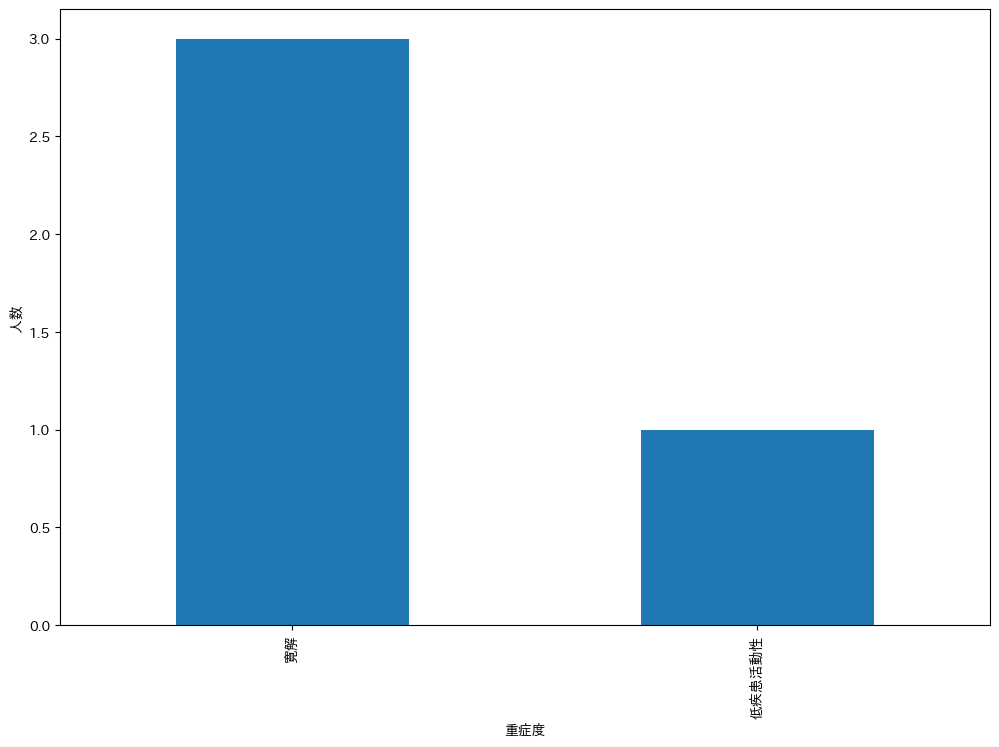

In [9]:
#label = ['寛解', '低疾患活動性', '中疾患活動性', '高疾患活動性']
label = ['寛解', '低疾患活動性']

df['RAPID3評価'].value_counts()[label].plot(kind='bar', tick_label=label,figsize=(12, 8))
plt.xlabel('重症度')
plt.ylabel('人数')

<AxesSubplot:>

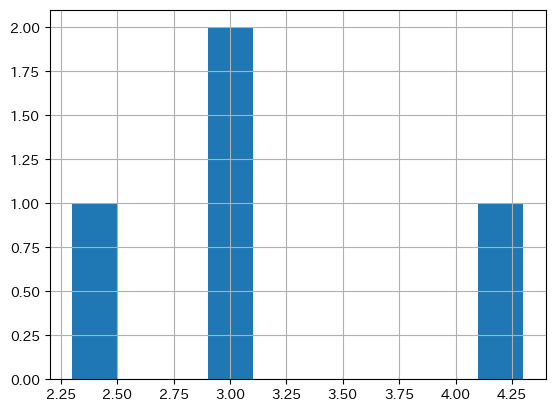

In [10]:
df['RAPID3'].hist()

In [36]:
pt_video_paths = defaultdict(dict)

for ptid in ptids:
    print('patient id is {}'.format(ptid))
    video_paths = sorted(glob.glob('data/病院で取得した動画/{}*'.format(ptid)))
    print('video num is {}'.format(len(video_paths)))
    #print(video_paths)
    print('---*---'*5)
    pt_video_paths[ptid] = video_paths

patient id is z02
video num is 20
---*------*------*------*------*---
patient id is z01
video num is 20
---*------*------*------*------*---


In [37]:
print(len(ptids))
ptids

2


['z02', 'z01']

In [38]:
print(pt_video_paths["z01"])

['data/病院で取得した動画/z01_movie1_day14_right.mp4', 'data/病院で取得した動画/z01_movie1_day1_left.mp4', 'data/病院で取得した動画/z01_movie1_day1_right.mp4', 'data/病院で取得した動画/z01_movie1_day28_left.mp4', 'data/病院で取得した動画/z01_movie1_day28_right.mp4', 'data/病院で取得した動画/z01_movie2_day14_right.mp4', 'data/病院で取得した動画/z01_movie2_day1_left.mp4', 'data/病院で取得した動画/z01_movie2_day1_right.mp4', 'data/病院で取得した動画/z01_movie2_day28_left.mp4', 'data/病院で取得した動画/z01_movie2_day28_right.mp4', 'data/病院で取得した動画/z01_movie3_day14_right.mp4', 'data/病院で取得した動画/z01_movie3_day1_left.mp4', 'data/病院で取得した動画/z01_movie3_day1_right.mp4', 'data/病院で取得した動画/z01_movie3_day28_left.mp4', 'data/病院で取得した動画/z01_movie3_day28_right.mp4', 'data/病院で取得した動画/z01_movie4_day14_right.mp4', 'data/病院で取得した動画/z01_movie4_day1_left.mp4', 'data/病院で取得した動画/z01_movie4_day1_right.mp4', 'data/病院で取得した動画/z01_movie4_day28_left.mp4', 'data/病院で取得した動画/z01_movie4_day28_right.mp4']


In [182]:
print(pt_video_paths["z01"].index("data/病院で取得した動画/z01_movie1_day28_left_annotated.mp4"))

ValueError: 'data/病院で取得した動画/z01_movie1_day28_left_annotated.mp4' is not in list

怪しい動画
- z01_movie2_day1_right_annotated.mp4
- z01_movie1_day28_left_annotated.mp4
- z01_movie2_day1_right_annotated.mp4
- z01_movie2_day28_left_annotated.mp4
- z01_movie2_day28_right_annotated.mp4
- z01_movie3_day1_left_annotated.mp4
- z01_movie3_day1_right_annotated.mp4
- z01_movie3_day28_left_annotated.mp4
- z01_movie3_day28_right_annotated.mp4
- z01_movie4_day1_left_annotated.mp4
- z01_movie4_day1_right_annotated.mp4
- z01_movie4_day14_right_annotated.mp4
- z01_movie4_day28_left_annotated.mp4
- z01_movie4_day28_right_annotated.mp4

In [39]:
print(len(pt_video_paths))

2


In [40]:
print(len(pt_video_paths["z01"]))
print(len(pt_video_paths["z02"]))

20
20


---

#### 病態で分ける
- 今回はほぼ意味ない

In [14]:
ts = target_df[target_df['ngrade']==0]
grade0_id = list(set(ts['ptid']))
print(grade0_id)
ts

['z02', 'z01']


,ptid,rapid3,grade,ngrade
1,z01,3.0,寛解,0
2,z01,2.3,寛解,0
3,z02,3.0,寛解,0


In [15]:
ts = target_df[target_df['ngrade']==1]
grade1_id = list(set(ts['ptid']))
print(grade1_id)
ts

['z02']


,ptid,rapid3,grade,ngrade
0,z02,4.3,低疾患活動性,1


In [16]:
ts = target_df[target_df['ngrade']==2]
grade2_id = list(set(ts['ptid']))
print(grade2_id)
ts

[]


,ptid,rapid3,grade,ngrade


In [17]:
ts = target_df[target_df['ngrade']==3]
grade3_id = list(set(ts['ptid']))
print(grade3_id)
ts

[]


,ptid,rapid3,grade,ngrade


## 2. 器官点検出

#### 対象動画や保存先の設定

In [93]:
video_path = pt_video_paths["z02"][0]
print(video_path)

data/病院で取得した動画/z02_movie1_day14_right.MOV


In [26]:
ext = video_path.split('/')[-1].split('.')[1]
print(ext)

mp4


In [228]:
# video_path指定
video_path = pt_video_paths["z01"][0]
#print(video_path)

# saveするかどうかの選択
save_movie = True
#save_movie = False


# save path
save_dir = 'data/saved_movie/clinic/'
makedir_if_notexists(save_dir)
mname = video_path.split('/')[-1].split('.')[0]
ext = video_path.split('/')[-1].split('.')[1]
save_movie_name = mname + '_annotated' # ここで動画名指定
if ext == "mp4":
    save_file_name = '{}.mp4'.format(save_movie_name)
else:
    save_file_name = '{}.MOV'.format(save_movie_name)
save_file = os.path.join(save_dir, save_file_name)
print('file name is {}'.format(save_file))

file name is data/saved_movie/clinic/z01_movie1_day14_right_annotated.mp4


#### 検出

In [189]:
# For webcam input:
#all_landmarks ={} # 各器官点ごとに時系列データを作成する
all_landmarks = defaultdict(list)

# opencv の扱いでも不明点あれば公式ドキュメントで
cap = cv2.VideoCapture(video_path)
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
print('FPS is {}'.format(frame_rate))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

size = (width, height)

# 動画保存
if save_movie:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(save_file, fourcc, frame_rate, size)

with mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            #print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # Flip the image horizontally for a later selfie-view display, and convert
        # the BGR image to RGB.
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        # To improve performance, optionally mark the image as not writeable to

        # reisize image
#         if image.shape[0] > resize_sh: # ここの条件適当なので今後修正する
#             image = cv2.resize(image, dsize=(width, height))

        # pass by reference.
        image.flags.writeable = False
        results = hands.process(image)

        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image_width, image_hight = image.shape[1], image.shape[0]
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # get real position
                landmark_x = []
                landmark_y = []

                for idx, landmark in enumerate(hand_landmarks.landmark):
                    # 正規化されているものを戻す
                    x = landmark.x * image_width
                    y = landmark.y * image_hight
                    landmark_x.append(x)
                    landmark_y.append(y)
                    all_landmarks['x_{}'.format(idx)].append(x)
                    all_landmarks['y_{}'.format(idx)].append(y)

                # drawing
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

            cv2.imshow('MediaPipe Hands', image)
            writer.write(image)
        #if cv2.waitKey(5) & 0xFF == 27:
        if cv2.waitKey(1) & 0xFF == ord('q'): # ここで動画の終了方法を指定。やりやすいように設定して頂ければ良いと思います。
            break
cap.release()
writer.release()
cv2.destroyAllWindows()

FPS is 23


---

In [384]:
# video_path指定
video_path = pt_video_paths["z02"][19]
#print(video_path)

# saveするかどうかの選択
save_movie = True
#save_movie = False


# save path
save_dir = 'data/saved_movie/clinic/'
makedir_if_notexists(save_dir)
mname = video_path.split('/')[-1].split('.')[0]
ext = video_path.split('/')[-1].split('.')[1]
save_movie_name = mname + '_annotated' # ここで動画名指定
if ext == "mp4":
    save_file_name = '{}.mp4'.format(save_movie_name)
else:
    save_file_name = '{}.MOV'.format(save_movie_name)
save_file = os.path.join(save_dir, save_file_name)
print('file name is {}'.format(save_file))

# For webcam input:
#all_landmarks ={} # 各器官点ごとに時系列データを作成する
all_landmarks = defaultdict(list)

# opencv の扱いでも不明点あれば公式ドキュメントで
cap = cv2.VideoCapture(video_path)
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
print('FPS is {}'.format(frame_rate))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

size = (width, height)

# 動画保存
if save_movie:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(save_file, fourcc, frame_rate, size)

with mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            #print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # Flip the image horizontally for a later selfie-view display, and convert
        # the BGR image to RGB.
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        # To improve performance, optionally mark the image as not writeable to

        # reisize image
#         if image.shape[0] > resize_sh: # ここの条件適当なので今後修正する
#             image = cv2.resize(image, dsize=(width, height))

        # pass by reference.
        image.flags.writeable = False
        results = hands.process(image)

        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image_width, image_hight = image.shape[1], image.shape[0]
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # get real position
                landmark_x = []
                landmark_y = []

                for idx, landmark in enumerate(hand_landmarks.landmark):
                    # 正規化されているものを戻す
                    x = landmark.x * image_width
                    y = landmark.y * image_hight
                    landmark_x.append(x)
                    landmark_y.append(y)
                    all_landmarks['x_{}'.format(idx)].append(x)
                    all_landmarks['y_{}'.format(idx)].append(y)

                # drawing
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

            cv2.imshow('MediaPipe Hands', image)
            writer.write(image)
        #if cv2.waitKey(5) & 0xFF == 27:
        if cv2.waitKey(1) & 0xFF == ord('q'): # ここで動画の終了方法を指定。やりやすいように設定して頂ければ良いと思います。
            break
cap.release()
writer.release()
cv2.destroyAllWindows()

file name is data/saved_movie/clinic/z02_movie4_day28_right_annotated.MOV
FPS is 30


In [385]:
# pickleで保存
import pickle

# save path
save_dir = 'files/coordinate/clinic'
makedir_if_notexists(save_dir)
fname = video_path.split('/')[-1].split('.')[0]
save_pickle_name = fname # ここで動画名指定
save_file_name = '{}.pickle'.format(save_movie_name)
save_file = os.path.join(save_dir, save_file_name)
print('file name is {}'.format(save_file))


with open(save_file, mode='wb') as f:
    pickle.dump(all_landmarks, f)

file name is files/coordinate/clinic/z02_movie4_day28_right_annotated.pickle


---

## 3. 取得した座標データを確認する
len(all_landmarks['x_0']), len(all_landmarks['x_1']), len(all_landmarks['y_8']), len(all_landmarks['y_6'])

In [338]:
# 取得した座標データを確認する
len(all_landmarks['x_0']), len(all_landmarks['x_1']), len(all_landmarks['y_8']), len(all_landmarks['y_6'])

(333, 333, 333, 333)

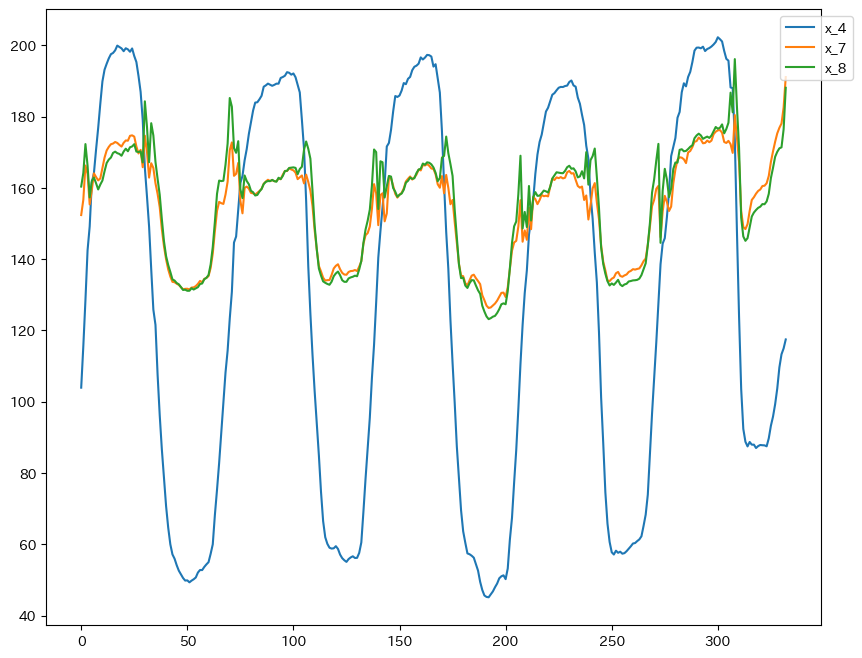

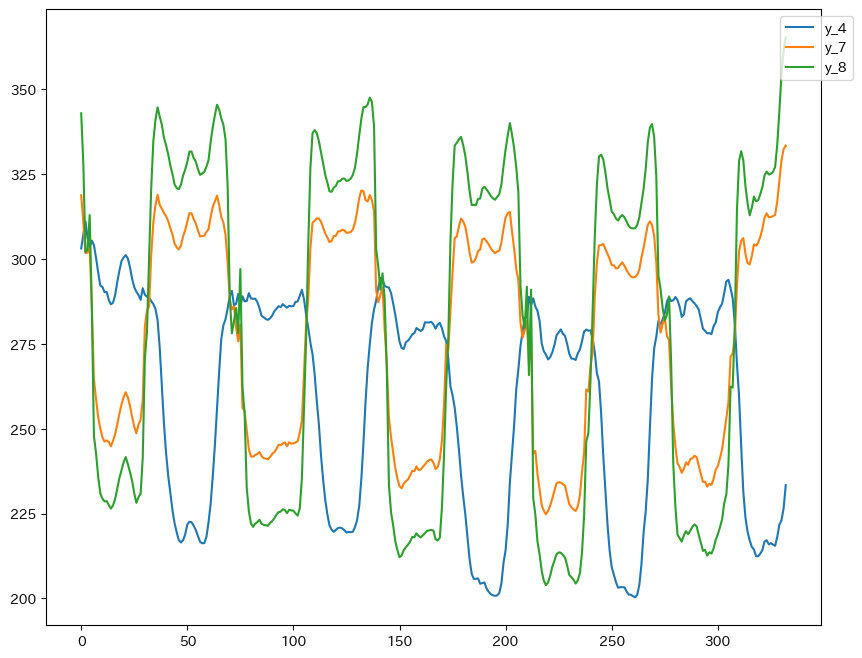

In [339]:
# とりあえず全体の可視化

# x
i = 0
xory = 'x'
plt.figure(figsize=(10,8))
plt.plot(all_landmarks['{0}_{1}'.format(xory, i+4)], label='{0}_{1}'.format(xory, i+4))
plt.plot(all_landmarks['{0}_{1}'.format(xory, i+7)], label='{0}_{1}'.format(xory, i+7))
plt.plot(all_landmarks['{0}_{1}'.format(xory, i+8)], label='{0}_{1}'.format(xory, i+8))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.show()

# y
i = 0
xory = 'y'
plt.figure(figsize=(10,8))
plt.plot(all_landmarks['{0}_{1}'.format(xory, i+4)], label='{0}_{1}'.format(xory, i+4))
plt.plot(all_landmarks['{0}_{1}'.format(xory, i+7)], label='{0}_{1}'.format(xory, i+7))
plt.plot(all_landmarks['{0}_{1}'.format(xory, i+8)], label='{0}_{1}'.format(xory, i+8))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.show()

#### 座標データの保存

In [274]:
video_paths = pt_video_paths["z01"]
print(video_paths)

['data/病院で取得した動画/z01_movie1_day14_right.mp4', 'data/病院で取得した動画/z01_movie1_day1_left.mp4', 'data/病院で取得した動画/z01_movie1_day1_right.mp4', 'data/病院で取得した動画/z01_movie1_day28_left.mp4', 'data/病院で取得した動画/z01_movie1_day28_right.mp4', 'data/病院で取得した動画/z01_movie2_day14_right.mp4', 'data/病院で取得した動画/z01_movie2_day1_left.mp4', 'data/病院で取得した動画/z01_movie2_day1_right.mp4', 'data/病院で取得した動画/z01_movie2_day28_left.mp4', 'data/病院で取得した動画/z01_movie2_day28_right.mp4', 'data/病院で取得した動画/z01_movie3_day14_right.mp4', 'data/病院で取得した動画/z01_movie3_day1_left.mp4', 'data/病院で取得した動画/z01_movie3_day1_right.mp4', 'data/病院で取得した動画/z01_movie3_day28_left.mp4', 'data/病院で取得した動画/z01_movie3_day28_right.mp4', 'data/病院で取得した動画/z01_movie4_day14_right.mp4', 'data/病院で取得した動画/z01_movie4_day1_left.mp4', 'data/病院で取得した動画/z01_movie4_day1_right.mp4', 'data/病院で取得した動画/z01_movie4_day28_left.mp4', 'data/病院で取得した動画/z01_movie4_day28_right.mp4']


In [279]:
# For webcam input:
#all_landmarks ={} # 各器官点ごとに時系列データを作成する
all_landmarks = defaultdict(list)

video_path = pt_video_paths["z01"][0]
# opencv の扱いでも不明点あれば公式ドキュメントで
cap = cv2.VideoCapture(video_path)
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
print('FPS is {}'.format(frame_rate))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

size = (width, height)

with mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            continue

        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

        image.flags.writeable = False
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image_width, image_hight = image.shape[1], image.shape[0]
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                landmark_x = []
                landmark_y = []

                for idx, landmark in enumerate(hand_landmarks.landmark):
                    # 正規化されているものを戻す
                    x = landmark.x * image_width
                    y = landmark.y * image_hight
                    landmark_x.append(x)
                    landmark_y.append(y)
                    all_landmarks['x_{}'.format(idx)].append(x)
                    all_landmarks['y_{}'.format(idx)].append(y)

                # drawing
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())

FPS is 29


In [202]:
# pickleで保存
import pickle

# save path
save_dir = 'files/coordinate/clinic'
makedir_if_notexists(save_dir)
for video_path in video_paths:
    fname = video_path.split('/')[-1].split('.')[0]
    save_pickle_name = fname # ここで動画名指定
    save_file_name = '{}.pickle'.format(save_movie_name)
    save_file = os.path.join(save_dir, save_file_name)
    print('file name is {}'.format(save_file))
    
    with open(save_file, mode='wb') as f:
        pickle.dump(all_landmarks, f)

file name is files/coordinate/clinic/z01_movie1_day1_left_annotated.pickle


In [386]:
# load pickle
#with open('files/coordinate/clinic/{0}_movie{1}_day{2}_{3}_annotated.pickle'.format(ptid, video_num+1, day, rorl), mode='rb') as f:
with open(save_file, mode='rb') as f:
    data = pickle.load(f)

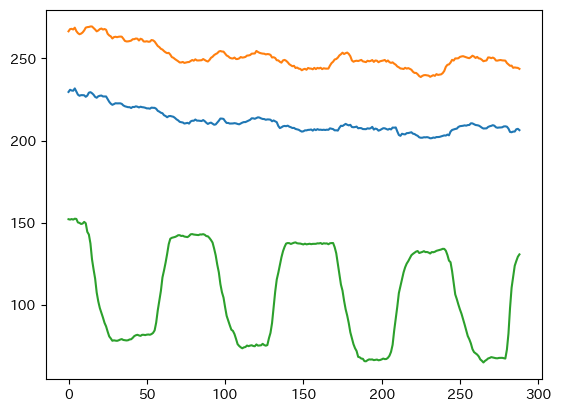

In [387]:
plt.plot(data['x_0'])
plt.plot(data['x_1'])
plt.plot(data['x_20'])

---

## 4. 指の震えについて検討する

In [418]:
import pickle

#保存時のファイル名の指定
def save_path_(ptid, video_num, xory, day, rorl, what):
    if what == "diff":
        save_path = "files/result/" + xory + "_diff/" + "{0}_movie{1}_day{2}_{3}_annotated.jpg".format(ptid, video_num, day, rorl)
    else:
        save_path = "files/result/" + xory + "/" + "{0}_movie{1}_day{2}_{3}_annotated.jpg".format(ptid, video_num, day, rorl)
    return save_path

#  指定の座標データ取得
def get_xy_pickle(ptid, video_num, xory, day, rorl):
    fpath = 'files/coordinate/clinic/{0}_movie{1}_day{2}_{3}_annotated.pickle'.format(ptid, video_num, day, rorl)
    with open(fpath, mode='rb') as f:
        d = pickle.load(f)
    return d

# 指定の座標データの階差取得
def get_xydiff_pickle(ptid, video_num, xory, fingnum, day, rorl):
    fpath = 'files/coordinate/clinic/{0}_movie{1}_day{2}_{3}_annotated.pickle'.format(ptid, video_num, day, rorl)
    with open(fpath, mode='rb') as f:
        d = pickle.load(f)
    d_diff = pd.DataFrame(d['{0}_{1}'.format(xory, fingnum)]).diff()
    return d_diff


# 各指の座標プロット
def plot_xory_each_pt(data, xory, save_path):
    plt.plot(data['{}_0'.format(xory)] , label='手首')
    plt.plot(data['{}_4'.format(xory)], label='親指')
    plt.plot(data['{}_8'.format(xory)], label='人差し指')
    plt.plot(data['{}_12'.format(xory)], label='中指')
    plt.plot(data['{}_16'.format(xory)], label='薬指')
    plt.plot(d['{}_20'.format(xory)], label='小指')
    plt.title('{}座標'.format(xory))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# 各指の座標階差プロット
def plot_diff_xory_each_pt(data, xory, save_path):
    diff0 = pd.DataFrame(data['{0}_{1}'.format(xory, 0)]).diff()
    diff4 = pd.DataFrame(data['{0}_{1}'.format(xory, 4)]).diff()
    diff8 = pd.DataFrame(data['{0}_{1}'.format(xory, 8)]).diff()
    diff12 = pd.DataFrame(data['{0}_{1}'.format(xory, 12)]).diff()
    diff16 = pd.DataFrame(data['{0}_{1}'.format(xory, 16)]).diff()
    diff20 = pd.DataFrame(data['{0}_{1}'.format(xory, 20)]).diff()

    diff = pd.concat([diff0, diff4+500, diff8+100, diff12+150, diff16+200, diff20+250], axis=1)
    diff.columns = ['手首', '親指', '人差し指', '中指', '薬指', '小指']
    diff.plot()
    plt.title('{}座標 階差'.format(xory))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    

###  まずは、生データを可視化する

個人毎の動きをここで確認する

座標については、間違いが無いように実際に確認もして頂きたいが、
- x座標：画像の左端が1, 右端が0
- y座標：画像の上端が0, 下端が１

In [410]:
coordinate_name = ["z01_movie4_day1_right_annotated.pickle", 
                    "z01_movie4_day14_right_annotated.pickle", 
                    "z01_movie4_day28_right_annotated.pickle", 
                    "z02_movie4_day1_right_annotated.pickle", 
                    "z02_movie4_day14_right_annotated.pickle", 
                    "z02_movie4_day28_right_annotated.pickle"]
print(coordinate_name)
ptid_list = []
video_num_list = []
xory_list = []
day_list = []
rorl_list = []
file_list = []
for file in coordinate_name:
    file_list.append(file)
    split_file = file.split("/")[-1].split("_")
    ptid_list.append(split_file[0])
    video_num_list.append(split_file[1][-1])
    day_list.append(split_file[2].split("y")[-1])
    rorl_list.append(split_file[3])

print(file_list)
print(ptid_list)
print(video_num_list)
print(xory_list)
print(day_list)
print(rorl_list)

['z01_movie4_day1_right_annotated.pickle', 'z01_movie4_day14_right_annotated.pickle', 'z01_movie4_day28_right_annotated.pickle', 'z02_movie4_day1_right_annotated.pickle', 'z02_movie4_day14_right_annotated.pickle', 'z02_movie4_day28_right_annotated.pickle']
['z01_movie4_day1_right_annotated.pickle', 'z01_movie4_day14_right_annotated.pickle', 'z01_movie4_day28_right_annotated.pickle', 'z02_movie4_day1_right_annotated.pickle', 'z02_movie4_day14_right_annotated.pickle', 'z02_movie4_day28_right_annotated.pickle']
['z01', 'z01', 'z01', 'z02', 'z02', 'z02']
['4', '4', '4', '4', '4', '4']
[]
['1', '14', '28', '1', '14', '28']
['right', 'right', 'right', 'right', 'right', 'right']


### 使用するデータはまさかのmovie4だけだった。だからday1, 14, 28の3パターンで2症例6データ。
使用データ
- z01_movie4_day1_right_annotated.pickle
- z01_movie4_day14_right_annotated.pickle
- z01_movie4_day28_right_annotated.pickle
- z02_movie4_day1_right_annotated.pickle
- z02_movie4_day14_right_annotated.pickle
- z02_movie4_day28_right_annotated.pickle

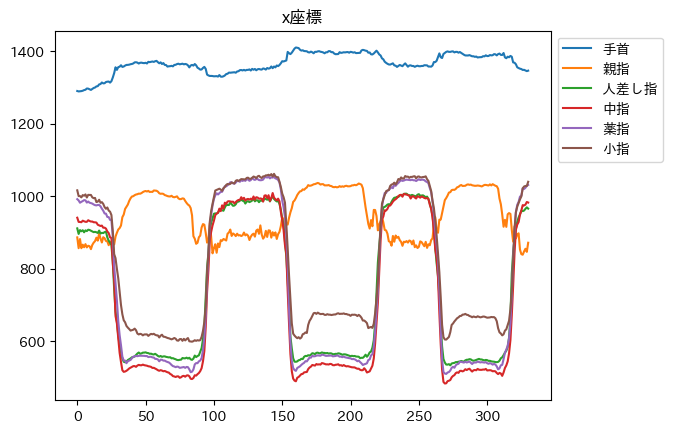

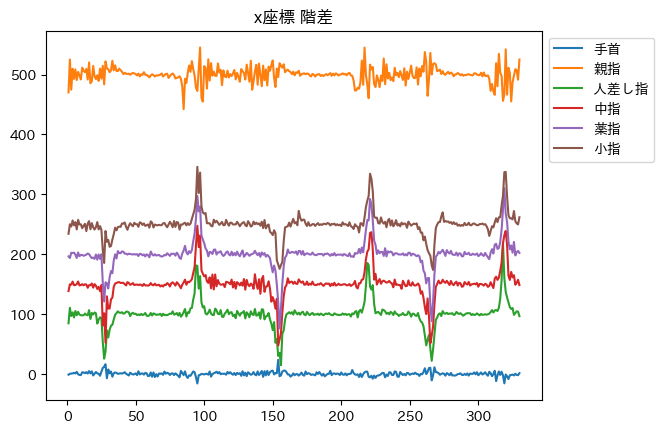

In [447]:
ptid = "z01"
video_num = 1
xory = 'x'
day = 1
rorl = "right"
d = get_xy_pickle(ptid, video_num, xory, day, rorl)

xory = 'x'
what = "x"
save_path = save_path_(ptid, video_num, xory, day, rorl, what)
plot_xory_each_pt(d, xory, save_path)
what = "diff"
save_path = save_path_(ptid, video_num, xory, day, rorl, what)
plot_diff_xory_each_pt(d, xory, save_path)

指の震えについて、偏差などで表現できないか確認  
     - 適切では無いかもしれないが、これである程表現できれば最も楽なので

In [390]:
video_num = 1 #  video種の指定
xory = 'x' # x座標か、y座標か
fingnum = 4 # 座標を取得する器官点の指定
day = 1
rorl = "left"

ptid = "z01"
diff = get_xydiff_pickle(ptid, video_num, xory, fingnum, day, rorl)
std= np.std(diff[30:50])
print(std)

0    1.660743
dtype: float64


上記では確認した箇所の、データ分布をざっくりと確認する

Text(0.5, 1.0, '人差し指x座標の階差の分布')

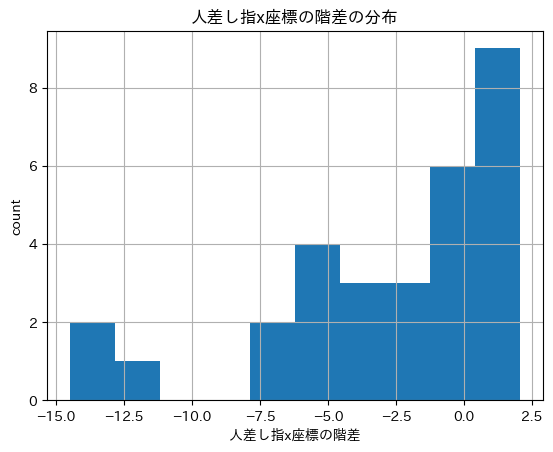

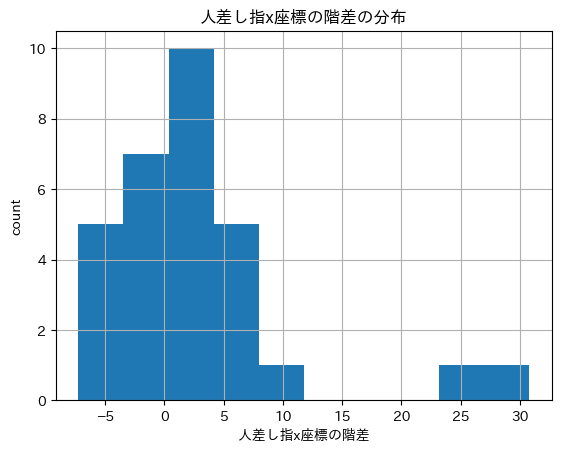

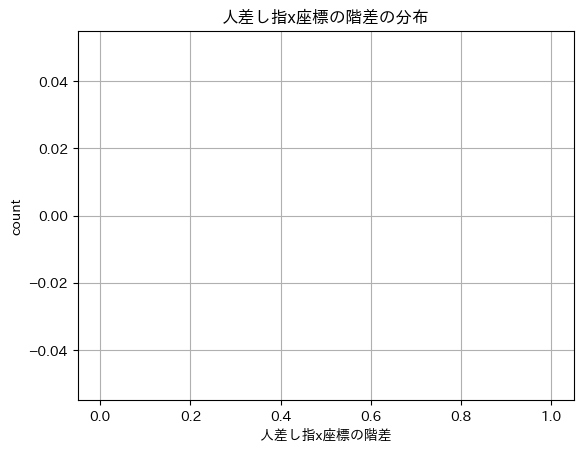

In [391]:
diff[50:80].hist()
plt.xlabel('人差し指x座標の階差')
plt.ylabel('count')
plt.title('人差し指x座標の階差の分布')

diff[190:220].hist()
plt.xlabel('人差し指x座標の階差')
plt.ylabel('count')
plt.title('人差し指x座標の階差の分布')

diff[320:350].hist()
plt.xlabel('人差し指x座標の階差')
plt.ylabel('count')
plt.title('人差し指x座標の階差の分布')

-  やはり、雑ではあるが揺れがある場合は標準偏差である程度は行けそう

###  簡易まとめ
#### 手の開閉の認識
- 開閉動作がスムーズでない人は、階差からの認識は難しそう
- 指の座標変異がmax時とmin時の平均との大小関係で判断するのが良さそう
    -  ただ、上記の開閉時の認識方法では、全く精緻には判断できないので、めちゃくちゃノイズが乗ってしまう。
    - めんどくさいが、個別にデータを取得するタイミングを指定する方法も試してみたい

#### 指の震え
- 最適では無いが、簡易的な表現にしたいので、stdで確認する


#### 備考
- id=3 : 手が開いた状態からstart。つまり、グラフだけを確認すると手の開閉のタイミングを逆に判断してしまいそう
- id=13 : 左手。つまり、各指のx座標の挙動が親指、人差し指と、薬指、小指が逆になる

---

## 5. 手の開閉の検出
- 以下は、適当な方法で手の開閉時を自動判断し、開いてる状態のみの指の揺れの情報を取得しようとしている
- しかし、手の開状態の前後部分も取得してしまう、動画や手全体ブレた時のブレも取得してしまうなど、精緻に状態を判断できないので非常にノイズが大きく、この方法での解析結果は全く信用できない

0    21.706902
dtype: float64


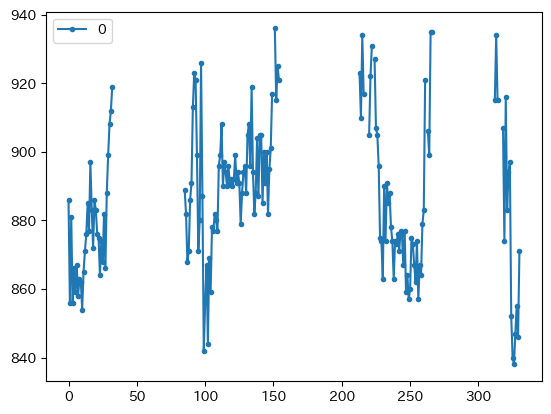

In [448]:
ptid = "z01"
video_num = 1
xory = 'x'
fingnum = 4
day = 1
rorl = "right"
d = get_xy_pickle(ptid, video_num, xory, day, rorl)
d_int = [int(s) for s in d['x_4']]
df_int = pd.DataFrame(d_int)
dat = df_int[df_int<(int(max(d['x_4']))+int(min(d['x_4'])))//2]
dat.plot(marker='.')
print(np.std(dat))

In [393]:
target_df[:3]

,ptid,rapid3,grade,ngrade
0,z02,4.3,低疾患活動性,1
1,z01,3.0,寛解,0
2,z01,2.3,寛解,0


ptid is z01 ,  rapid3 is 3.0 , ngrade is 0, day1
standard deviation is 51.37


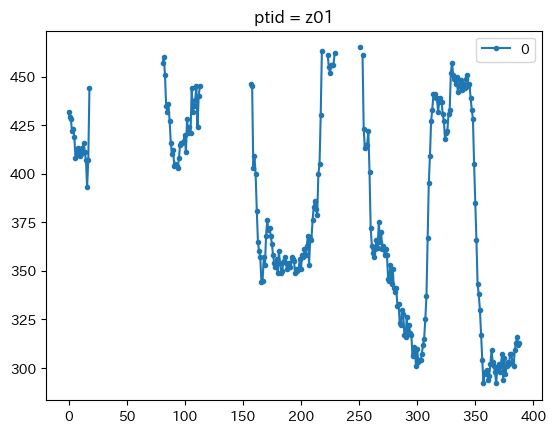

---*------*------*------*------*------*------*------*------*------*---
ptid is z01 ,  rapid3 is 3.0 , ngrade is 0, day14
standard deviation is 33.45


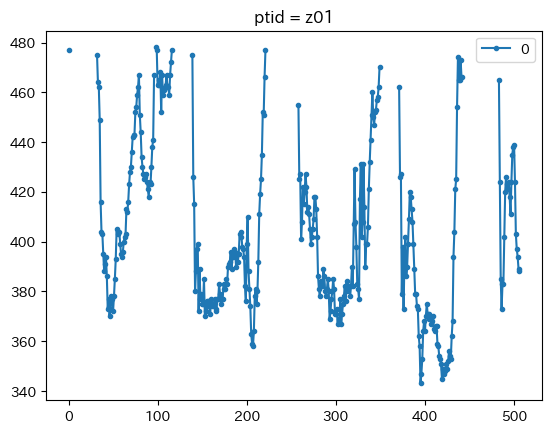

---*------*------*------*------*------*------*------*------*------*---
ptid is z01 ,  rapid3 is 3.0 , ngrade is 0, day28
standard deviation is 24.51


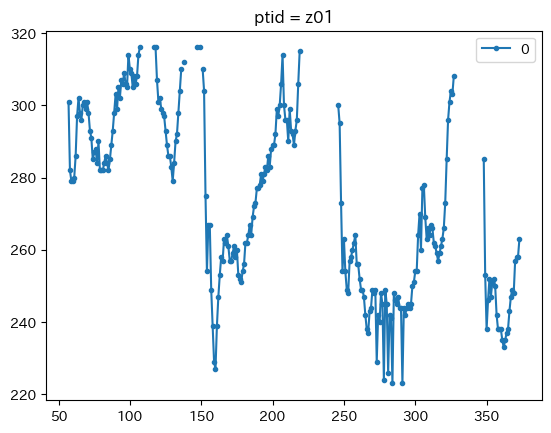

---*------*------*------*------*------*------*------*------*------*---
ptid is z02 ,  rapid3 is 4.3 , ngrade is 1, day1
standard deviation is 18.63


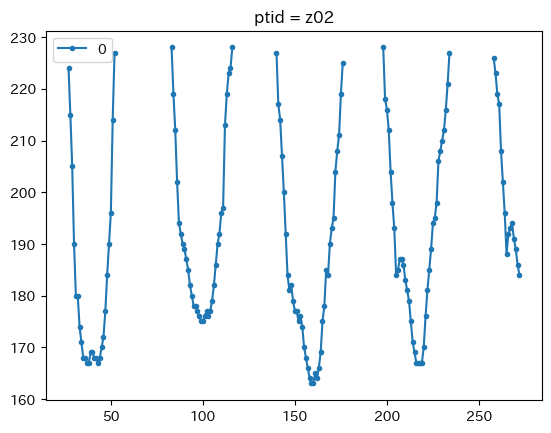

---*------*------*------*------*------*------*------*------*------*---
ptid is z02 ,  rapid3 is 4.3 , ngrade is 1, day14
standard deviation is 15.8


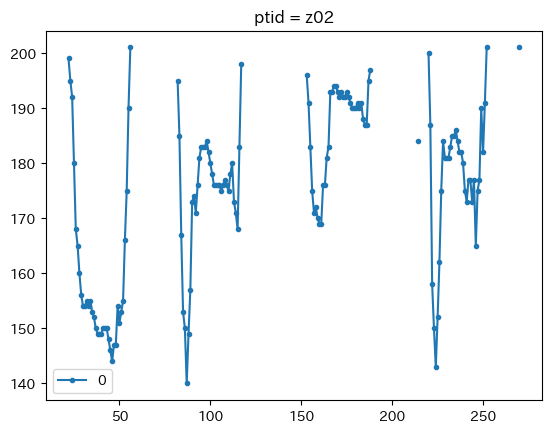

---*------*------*------*------*------*------*------*------*------*---
ptid is z02 ,  rapid3 is 4.3 , ngrade is 1, day28
standard deviation is 10.53


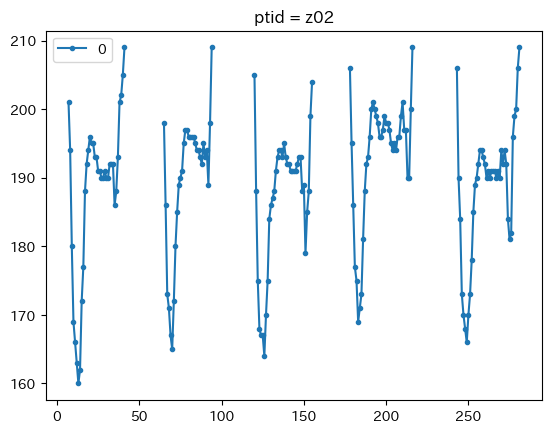

---*------*------*------*------*------*------*------*------*------*---


In [450]:
ptids = ["z01", "z02"]
days = [1, 14, 28]
# set params
ptid = "z01"
video_num = 2
xory = 'x'
fingnum = 4
day = 1
rorl = "right"
column = '{0}_{1}'.format(xory, fingnum)

pt_ids = []
stds = []
rapid3s = []
ngrades = []
grades = []

for ptid in ptids:
    for day in days:
        save_name = "files/result/thumb_x_diff/" + ptid + "_movie4_day" + str(day) + "_right_annotated.jpg"
        try:
            d= get_xy_pickle(ptid, video_num, xory, day, rorl)
            dat =  target_df[target_df['ptid']==ptid].reset_index(drop=True)
            rapid3 = dat['rapid3'][0]
            ngrade = dat['ngrade'][0]
            grade = dat['grade'][0]
            print('ptid is {0} ,  rapid3 is {1} , ngrade is {2}, day{3}'.format(ptid, rapid3, ngrade, day))
            d_int = [int(s) for s in d[column]]
            df_int = pd.DataFrame(d_int)
            dat = df_int[df_int<(int(max(d[column]))+int(min(d[column])))//2]
            std = np.round(np.std(dat)[0],2)
            print('standard deviation is {}'.format(std))
            dat.plot(marker='.')
            plt.title('ptid = {}'.format(ptid))
            #plt.savefig(save_name, bbox_inches='tight')
            plt.show()
            pt_ids.append(ptid)
            stds.append(std)
            rapid3s.append(rapid3)
            ngrades.append(ngrade)
            grades.append(grade)
            print('---*---'*10)
        except FileNotFoundError:
            print('FileNotFoundError : ptid is {}'.format(ptid))
            print('---*---'*10)

- 何となく、おおよそだが手を開いた時の座標が取得できてそう

In [442]:
pt_df = pd.DataFrame([pt_ids, rapid3s, ngrades, stds]).T
pt_df.columns = ['ptid'] + ['rapid3'] + ['ngrade'] + ['std']
pt_df = pt_df.sort_values('ptid')
print('data length is {}'.format(len(pt_df)))
pt_df

data length is 6


,ptid,rapid3,ngrade,std
0,z01,3.0,0,27.96
1,z01,3.0,0,38.06
2,z01,3.0,0,31.73
3,z02,4.3,1,15.0
4,z02,4.3,1,15.03
5,z02,4.3,1,12.78


In [443]:
pt_df.groupby('ngrade')['std'].mean()

ngrade
0    32.583333
1    14.270000
Name: std, dtype: float64

In [444]:
pt_df['grade'] = pt_df['ngrade'].map({3.0: '高疾患活動性', 2.0: '中疾患活動性', 1.0: '低疾患活動性', 0.0: '寛解'})
pt_df['ngrade'] = pt_df['ngrade'].map({3.0: 3, 2.0: 2, 1.0: 1, 0.0: 0})
pt_df.head()

,ptid,rapid3,ngrade,std,grade
0,z01,3.0,0,27.96,寛解
1,z01,3.0,0,38.06,寛解
2,z01,3.0,0,31.73,寛解
3,z02,4.3,1,15.0,低疾患活動性
4,z02,4.3,1,15.03,低疾患活動性


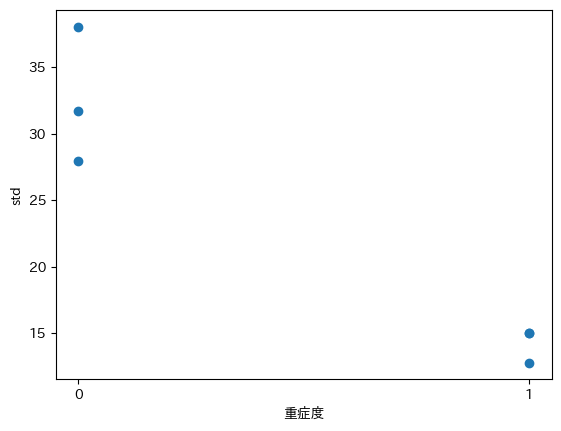

ValueError: object arrays are not supported

In [445]:
import matplotlib.ticker as plticker
import seaborn as sns

label = ['寛解', '低疾患活動性', '中疾患活動性', '高疾患活動性']

fig, ax = plt.subplots()
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

plt.scatter(pt_df['ngrade'], pt_df['std'])
plt.xlabel('重症度')
plt.ylabel('std')
plt.show()

sns.violinplot(x=pt_df['ngrade'], y=pt_df['std'])
plt.xlabel('重症度')
plt.show()

- 厳密じゃないし、データ少ないし、個人差もあるのでなんとも言えない
- もう少し方法を考える
    - __あれなら、手作業で必要部分を取得し上記内容を算出する__

### 動画毎にstdを算出するタイミングを決定し、上記のグラフをもう少し詳細に算出する

#### まずは、詳細の解析に用いる被験者を下記にする
- ptid: 3, 5, 13, 17, 22, 25, 32, 34, 35
- 選択理由：
    - 手の動画の撮影が比較的綺麗に行えている
    - カメラの手ブレや手全体のブレが比較的少ない

選んだ被験者の重症度情報を確認する

In [110]:
target_user_ids = [3, 5, 13, 17, 22, 25, 32, 34, 35]
td = target_df[target_df['ptid'].isin(target_user_ids)]
td = td.drop_duplicates(subset='ptid')
td

,ptid,rapid3,grade,ngrade
0,32,12.3,高疾患活動性,3
1,25,3.0,寛解,0
3,22,10.0,中疾患活動性,2
5,5,8.0,中疾患活動性,2
12,3,15.7,高疾患活動性,3
14,13,21.0,高疾患活動性,3
15,17,2.3,寛解,0
17,35,21.3,高疾患活動性,3
20,34,5.3,低疾患活動性,1


<AxesSubplot:>

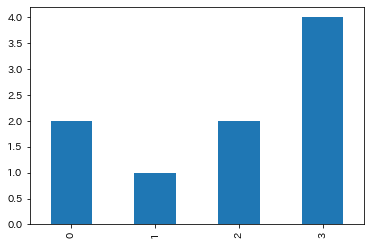

In [111]:
td['ngrade'].value_counts().sort_index().plot(kind='bar')

一旦、適当な自動判定の方法で上記被験者のみで確認してみる
- とりあえず、手の全体のブレやカメラの手ぶれといったノイズはある程度低減可能なはずなので。

ptid is 32 ,  rapid3 is 12.3 , ngrade is 3
standard deviation is 50.83


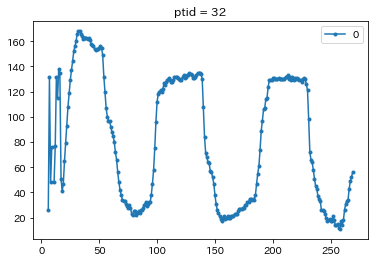

---*------*------*------*------*------*------*------*------*------*---
ptid is 34 ,  rapid3 is 5.3 , ngrade is 1
standard deviation is 31.09


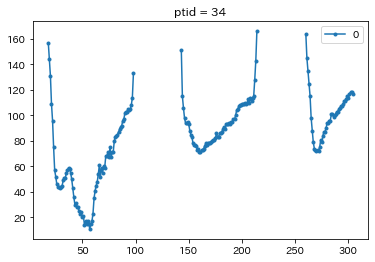

---*------*------*------*------*------*------*------*------*------*---
ptid is 3 ,  rapid3 is 15.7 , ngrade is 3
standard deviation is 19.37


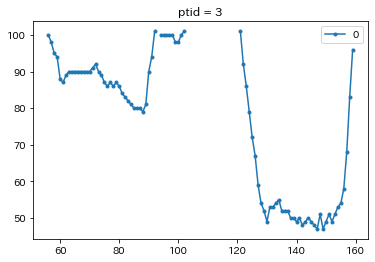

---*------*------*------*------*------*------*------*------*------*---
FileNotFoundError : ptid is 35
---*------*------*------*------*------*------*------*------*------*---
ptid is 5 ,  rapid3 is 8.0 , ngrade is 2
standard deviation is 45.37


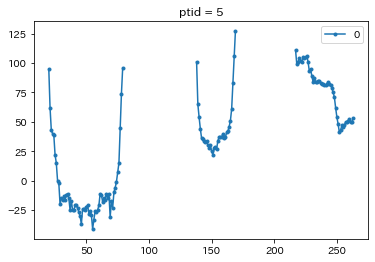

---*------*------*------*------*------*------*------*------*------*---
ptid is 13 ,  rapid3 is 21.0 , ngrade is 3
standard deviation is 21.19


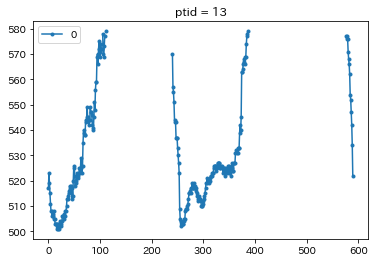

---*------*------*------*------*------*------*------*------*------*---
ptid is 17 ,  rapid3 is 2.3 , ngrade is 0
standard deviation is 22.74


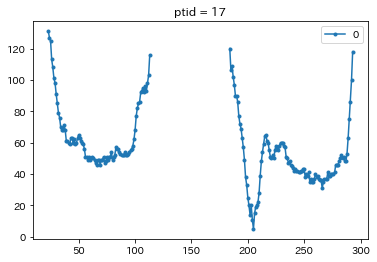

---*------*------*------*------*------*------*------*------*------*---
ptid is 22 ,  rapid3 is 10.0 , ngrade is 2
standard deviation is 13.06


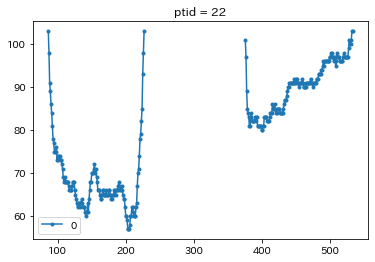

---*------*------*------*------*------*------*------*------*------*---
ptid is 25 ,  rapid3 is 3.0 , ngrade is 0
standard deviation is 19.45


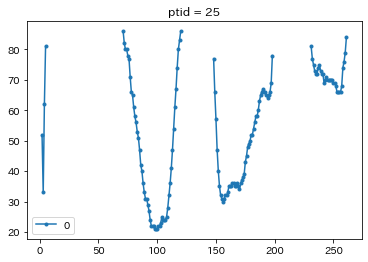

---*------*------*------*------*------*------*------*------*------*---


In [112]:
ptids = list(set(td.sort_values('ptid')['ptid']))

# set params
video_num = 4
xory = 'x'
fignum = 4
column = '{0}_{1}'.format(xory, fignum)

pt_ids = []
stds = []
rapid3s = []
ngrades = []
grades = []

for ptid in ptids:
    try:
        d= get_xy_pickle(ptid, video_num, xory)
        dat =  target_df[target_df['ptid']==ptid].reset_index(drop=True)
        rapid3 = dat['rapid3'][0]
        ngrade = dat['ngrade'][0]
        grade = dat['grade'][0]
        print('ptid is {0} ,  rapid3 is {1} , ngrade is {2}'.format(ptid, rapid3, ngrade))
        d_int = [int(s) for s in d[column]]
        df_int = pd.DataFrame(d_int)
        dat = df_int[df_int<(int(max(d[column]))+int(min(d[column])))//2]
        std = np.round(np.std(dat)[0],2)
        print('standard deviation is {}'.format(std))
        dat.plot(marker='.')
        plt.title('ptid = {}'.format(ptid))
        plt.show()
        pt_ids.append(ptid)
        stds.append(std)
        rapid3s.append(rapid3)
        ngrades.append(ngrade)
        grades.append(grade)
        print('---*---'*10)
    except FileNotFoundError:
        print('FileNotFoundError : ptid is {}'.format(ptid))
        print('---*---'*10)

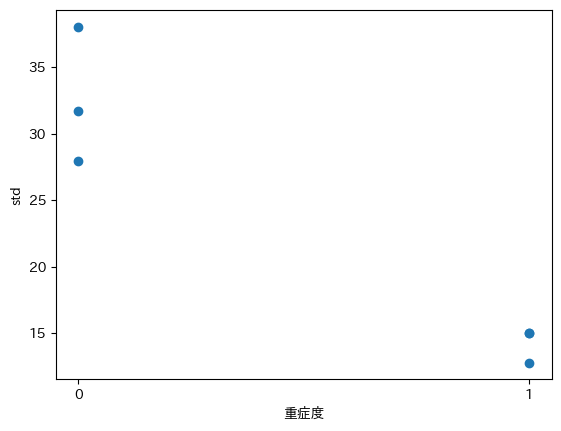

ValueError: object arrays are not supported

In [446]:
label = ['寛解', '低疾患活動性', '中疾患活動性', '高疾患活動性']

fig, ax = plt.subplots()
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

plt.scatter(pt_df['ngrade'], pt_df['std'])
plt.xlabel('重症度')
plt.ylabel('std')
plt.show()

sns.violinplot(x=pt_df['ngrade'], y=pt_df['std'])
plt.xlabel('重症度')
plt.show()

#### 考察
- 結局下記の理由によりよくわからない
    - データ数が少ない
    - 個人の癖、器用さ、撮り方はやはりどこまで行こうとノイズになり得る
    　- そもそもmediapipeの検出がぶれやすいので、どこまで指の震えを取れているのかも不明
     - 今回余計なノイズを極力減らすために恣意的に使用するタイミングを決めたが、その方法もどこまで良い方法で選べているのかも不明
     -  理想的には、開いているタイミングの短時間のデータ一発ではなく、開いている時間帯のデータをより長く精度良く使うようにしないとやろうとしている目的の評価には適していない
     
#### しかしながら
-  初期的解析である程度丁寧にデータを確認したので一旦はこれで良いということにする

---